#### Importamos las librerías necesarias

In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from googletrans import Translator

#### Abrimos el modelo

In [2]:
with open('../model/sentiment_model', "rb") as archivo_entrada:
    model = pickle.load(archivo_entrada)

C:\Users\Celia\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Celia\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Celia\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 1.2.1. This might lead to 

In [3]:
tweets = pd.read_csv('../data/tweets.csv')

#### Traducimos los tweets que no están en castellano

In [4]:
translator = Translator()
def translate_tweet(tweet):
    if translator.detect(tweet).lang == 'eu':
        return translator.translate(tweet, src='eu', dest='es').text
    else:
        return tweet

In [7]:
tweets['text_trans'] = tweets['text'].apply(translate_tweet)

#### Limpiamos el texto

In [8]:
# Función para Procesar y limpiar dataframe 

def nlp_clean(df, column, language):

    #Borramos los missing values
    df.dropna(inplace=True)
    
    # Eliminamos los duplicados
    df.drop_duplicates(inplace=True)

    #Eliminamos menciones
    df[column] = df[column].str.replace(r'\s*@\w+', '', regex=True)

    #Eliminamos signos de puntuación y pasamos a minúsculas
    signos = re.compile("(\.)|(\;)|(\:)|(\¡)|(\#)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

    def signs_tweets(tweet):
        return signos.sub('', tweet.lower())

    df[column] = df[column].apply(signs_tweets)
    
    #Eliminamos links
    def remove_links(df):
        return " ".join([' ' if ('http') in word else word for word in df.split()])
    
    df[column] = df[column].apply(remove_links)

    #Eliminamos stopwords
    stopwords_lang = stopwords.words(language)
    def remove_stopwords(df):
        return " ".join([word for word in df.split() if word not in stopwords_lang])
    
    df[column] = df[column].apply(remove_stopwords)

    #Stemmer
    stemmer = SnowballStemmer(language)

    def def_stemmer(x):
        return " ".join([stemmer.stem(word) for word in x.split()])

    df[column] = df[column].apply(def_stemmer)

    #Guardamos los datos procesados
    final_df = df[[column]]
    return final_df

In [9]:
df = nlp_clean(tweets, 'text_trans', 'spanish')

#### Predicciones

In [10]:
predictions = model.predict(df['text_trans'])
df.loc[:,'pred_bin'] = pd.Series(predictions)

df

C:\Users\Celia\AppData\Local\Temp\ipykernel_20364\2368389655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'pred_bin'] = pd.Series(predictions)


,text_trans,pred_bin
0,inscripcion realiz eventbrit cualqui dud md co...,0
1,fin pod public cartel ponent cybersectalks si ...,0
2,encuentr madr mlops trincher ven conoc practic...,1
3,buen fot circul bell artes,0
4,,0
...,...,...
123,organiz i congres cibersegur pymes 📅 diciembr ...,0
124,🔵aceler carrer digital bbkbootcamps graci cola...,0
125,aceler junt talentodigital españ proxim noviem...,1
126,aprend oper futur hoy registres bbkbootcamp ⏩ ...,0


In [42]:
# Predicciones de probabilidad
predictions = model.predict_proba(df['text_trans'])
# Obtener la probabilidad de la clase positiva y negativa
pos_probs = predictions[:, 1]
neg_probs = predictions[:, 0]

# Agregar las columnas de predicción al dataframe original
df['polarity_pos'] = pos_probs
df['polarity_neg'] = neg_probs

C:\Users\Celia\AppData\Local\Temp\ipykernel_16564\150727.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Celia\AppData\Local\Temp\ipykernel_16564\150727.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
# Guardar las predicciones
df.to_csv('data/predictions.csv')

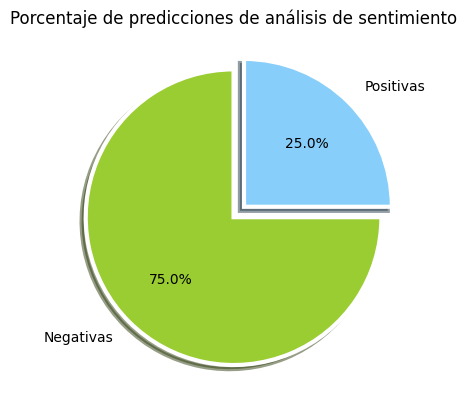

In [14]:
# Crear el gráfico de tarta
colors = ['yellowgreen', 'lightskyblue']
explode = (0, 0.1)  

plt.pie(df['pred_bin'].value_counts(), labels=['Negativas', 'Positivas'], colors=colors, startangle=0, counterclock=False, explode=explode, shadow=True, autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

# Establecer el título
plt.title('Porcentaje de predicciones de análisis de sentimiento')

# Mostrar el gráfico
plt.savefig('img/pred_percentage.png')
plt.show()

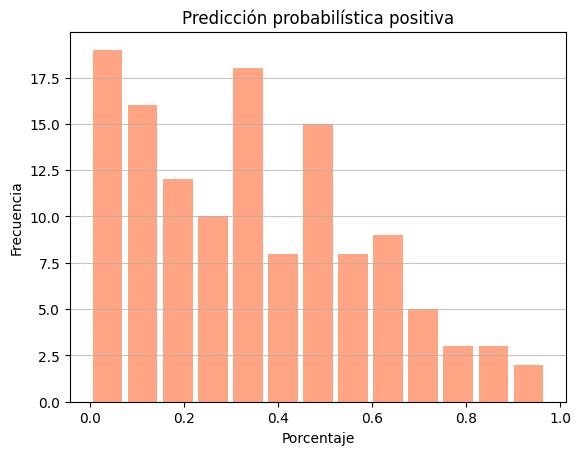

In [57]:
# Gráfico de la predicción probabilística

plt.hist(x=df['polarity_pos'], bins=13, color='coral',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Porcentaje')
plt.ylabel('Frecuencia')
plt.title('Predicción probabilística positiva')
plt.savefig('img/pred_proba.png')


#### Variables más importantes del modelo (palabras positivas y negativas)

In [21]:
# Obtener todos los coeficientes
coeficients = model.named_steps['cls'].coef_[0]

In [22]:
# Obtener los nombres de las características (palabras) del CountVectorizer
feature_names = model.named_steps['vect'].get_feature_names_out()

In [23]:
# Crear un diccionario con los coeficientes y las características
# Montar un diccionario con palabra -> coeficiente
feature_to_coef = {
    word: coef for word, coef in zip(
        feature_names, coeficients
    )
}


for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print(best_positive)
    
print('################################')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print(best_negative)
    

('cuent', 1.427233666085361)
('deficit', 1.4022058325629765)
('blanc', 1.368604445686843)
('muert', 1.3502570413482133)
('conden', 1.3429067328197288)
################################
('encant', -1.8605111981502893)
('enhorabuen', -1.8449366081495842)
('graci', -1.805329609096349)
('buen', -1.6751185631684895)
('feliz', -1.4730851687952473)


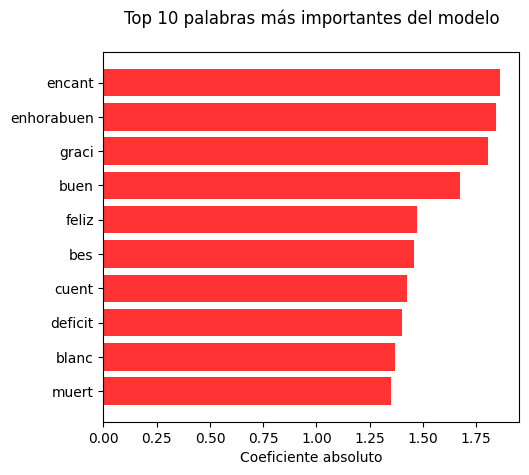

In [26]:
# Obtener las 10 palabras más importantes en valores absolutos
top_features = sorted(feature_to_coef.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
top_features.reverse()

# Crear la figura
fig, ax = plt.subplots()

# Crear la gráfica de barras horizontales
ax.barh([i for i in range(len(top_features))], [abs(x[1]) for x in top_features], color="#ff3333")

# Añadir etiquetas al eje y
ax.set_yticks([i for i in range(len(top_features))])
ax.set_yticklabels([x[0] for x in top_features])

# Añadir etiquetas al eje x
ax.set_xlabel("Coeficiente absoluto")

# Añadir título
ax.set_title("Top 10 palabras más importantes del modelo", pad=20)

# Ajustar los márgenes de la figura
plt.subplots_adjust(left=0.25)

# Mostrar la figura
plt.savefig('../img/feature_imp.png')

plt.show()



#### Palabras más frecuentes en los tweets positivos y negativos

In [35]:
def plot_ngrams(df, target:str, text:str, n_gram:int):
    import plotly.graph_objs as go
    from plotly import tools
    from collections import defaultdict
    import pandas as pd
    import plotly.offline as py
    from wordcloud import STOPWORDS

    df1 = df[df[target] ==1]
    df0 = df[df[target] ==0]
    ## custom function for ngram generation ##
    def generate_ngrams(text, n_gram):
        token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]
    ## custom function for horizontal bar chart ##
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation='h',
            marker=dict(
                color=color,
            ),
        )
        return trace

    ## Get the bar chart from text with label 0 ##
    freq_dict = defaultdict(int)
    for sent in df0[text]:
        for word in generate_ngrams(sent, n_gram):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(50), color='#3F979B')

    ## Get the bar chart from text with label 1 ##
    freq_dict = defaultdict(int)
    for sent in df1[text]:
        for word in generate_ngrams(sent, n_gram):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace1 = horizontal_bar_chart(fd_sorted.head(50), color='#F9F54B')

    # Creating two subplots
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Palabras frecuentes en tweets negativos", 
                                          "Palabras frecuentes en tweets positivos"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    fig.write_image("../img/plot_ngrams.png")
    py.iplot(fig, filename='word-plots')

In [36]:
plot_ngrams(df, 'pred_bin', 'text_trans', 1)

C:\Users\Celia\AppData\Roaming\Python\Python39\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

